This notebook reproduces some of the figures generated for the **Unifying developmental and evoked response dynamics
** chapter of my thesis which can be downloaded [here](https://github.com/jlstevens/thesis/raw/master/thesis.pdf). This notebook requires a version of Topographica that has the CGCAL and TCAL models available, introduced in [this PR](https://github.com/ioam/topographica/pull/665).


In particular, this notebook generates the CGCAL portions of Figure 6.1 (i.e parts **B** and **C**), the CGCAL portions of Figure 6.2 (i.e row **C**) and the CGCAL map in Figure 6.3:

[Figure 6.1](https://github.com/jlstevens/thesis/blob/master/figures/CGCAL_LGN.pdf) : **Comparison of ON sheet responses as received by V1 units in the GCAL and CGCAL (with and without hysteresis) in response to an isotropic Gaussian stimulus.**
<br>
[Figure 6.2](https://github.com/jlstevens/thesis/blob/master/figures/V1_activity_CGCAL.pdf) : **Comparison of responses to horizontal line in GCAL and CGCAL models after 5000 training iterations.**
<br>
[Figure 6.3](https://github.com/jlstevens/thesis/blob/master/figures/CGCAL_OR_map.pdf) : ** Comparison between GCAL and CGCAL orientation maps after 20000 iterations.**

First we start by importing the key packages and activating the HoloViews extension:

In [1]:
import imagen
import numbergen
import numpy as np
import holoviews as hv
hv.notebook_extension()

We will want to render output to SVG:

In [2]:
%output fig='svg'

Next, the ``ModelCGCAL`` class is imported together with the necessary analysis and measurement code:

In [3]:
import topo
from topo.submodel.cgcal import ModelCGCAL 
from topo.analysis import Collector

import featuremapper
from featuremapper.command import measure_or_pref, measure_response
from featuremapper.analysis.hypercolumns import PowerSpectrumAnalysis

from featuremapper.analysis import pinwheels

## Load model and specify ``Collector``

Now we can initialize the CGCAL model:

In [4]:
topo.sim.model = ModelCGCAL()
topo.sim()

Time: 000000.00 ModelSpec: Modifying time functions to reproduce GCAL Gaussian sequence


And define the necessary measurements that need to be recorded:

In [5]:
c = Collector()
model = topo.sim.model.specification
# Preference map measurement (e.g. orientation and center of gravity plots)
c.collect(measure_or_pref)
c.collect(measure_response.instance(input_patterns={'Retina':imagen.SineGrating()},
                           durations=list(np.linspace(0,1, 26))))

c.Activity.Retina =         c.collect(model.sheets.Retina)
c.Activity.V1 =             c.collect(model.sheets.V1)

## Figure 6.1B (CGCAL PSTHS without hysteresis)

[Figure 6.1](https://github.com/jlstevens/thesis/blob/master/figures/CGCAL_LGN.pdf) : **Comparison of ON sheet responses as received by V1 units in the GCAL and CGCAL (with and without hysteresis) in response to an isotropic Gaussian stimulus.**

First we will grab a copy of the output functions on the LGN ON and OFF sheets as we will want to restore them later:

In [6]:
restore_of_OFF = topo.sim.LGNOff.output_fns[:]
restore_of_ON = topo.sim.LGNOn.output_fns[:]

As the hysteresis mechanism is the last output function on the LGN sheets, we can slice it off to disable hysteresis in the CGCAL model completely: 

In [7]:
topo.sim.LGNOn.output_fns = topo.sim.LGNOn.output_fns[:1]
topo.sim.LGNOff.output_fns = topo.sim.LGNOff.output_fns[:1]

Now we can record the temporal profile of the responses in the CGCAL LGNw with hysteresis disabled (Figure 6.1B):

In [8]:
%%opts GridSpace [xaxis=None yaxis=None] Curve [xaxis=None yaxis=None show_grid=False] Curve (color='k')
response=measure_response.instance(input_patterns={'Retina':imagen.Gaussian(aspect_ratio=1, size=0.4)}, 
                                   outputs=['LGNOnAfferent'],
                           durations=list(np.linspace(0,1, 26)))()
LGN_response = response.GaussianResponse.LGNOnAfferent
LGN_response.sample((11,11),bounds=(-0.45, -0.45, 0.45, 0.45)).to.curve(['Duration'], ['z']).grid(['x','y'])

:GridSpace   [x,y]
   :HoloMap   [Time]
      :Curve   [Duration]   (z)

## Figure 6.1C (CGCAL PSTHS with hysteresis)

We can now restore the output functions to re-enable the hysteresis mechanism

In [9]:
topo.sim.LGNOn.output_fns = restore_of_ON
topo.sim.LGNOff.output_fns = restore_of_OFF

In [10]:
%%opts GridSpace [xaxis=None yaxis=None] Curve [xaxis=None yaxis=None show_grid=False] Curve (color='k')
response=measure_response.instance(input_patterns={'Retina':imagen.Gaussian(aspect_ratio=1, size=0.4)}, 
                                   outputs=['LGNOnAfferent'],
                           durations=list(np.linspace(0,1, 26)))()
LGN_response = response.GaussianResponse.LGNOnAfferent
LGN_response.sample((11,11),bounds=(-0.45, -0.45, 0.45, 0.45)).to.curve(['Duration'], ['z']).grid(['x','y'])

:GridSpace   [x,y]
   :HoloMap   [Time]
      :Curve   [Duration]   (z)

:Layout
   .LineResponse.V1     :HoloMap   [Time,Duration]
      :Image   [x,y]   (z)
   .LineResponse.Retina :HoloMap   [Time,Duration]
      :Image   [x,y]   (z)
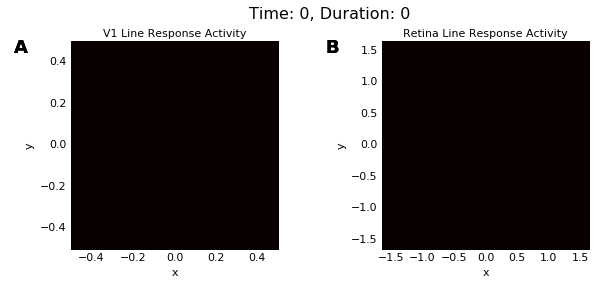
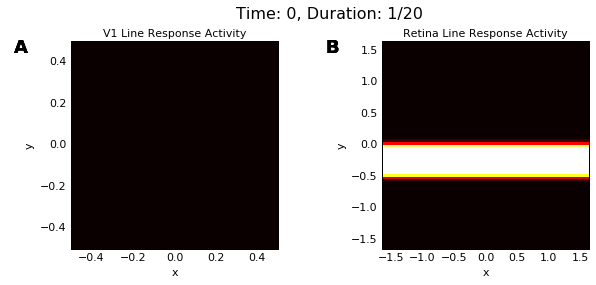
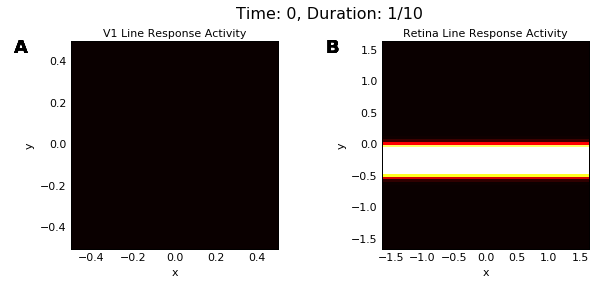
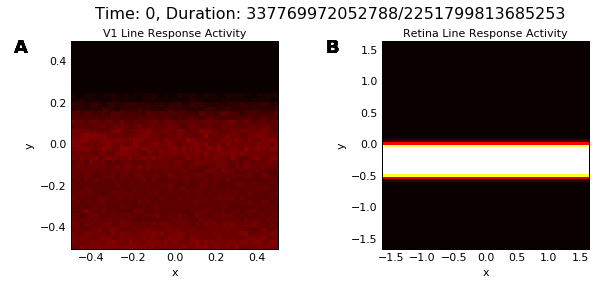
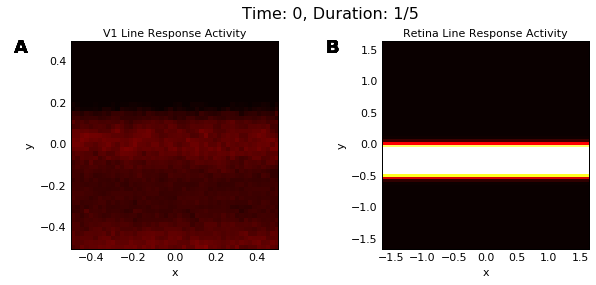
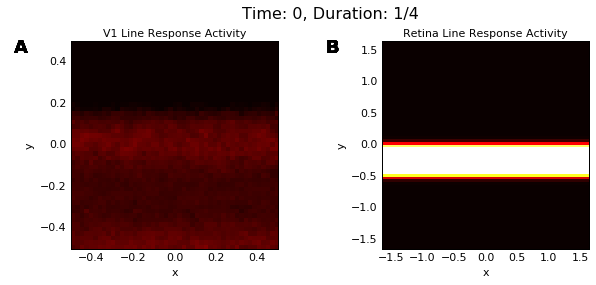
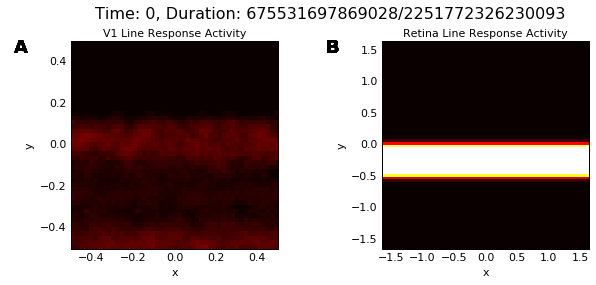
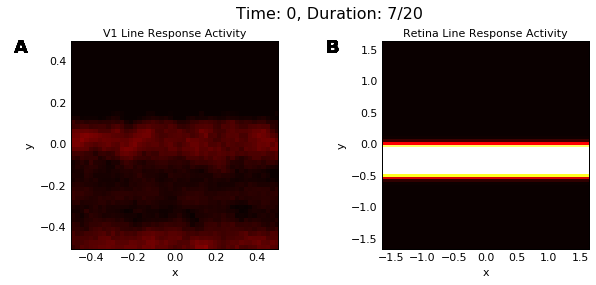
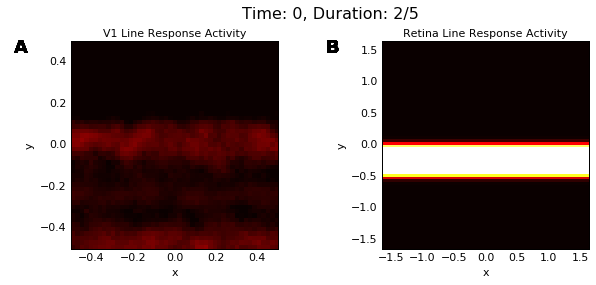
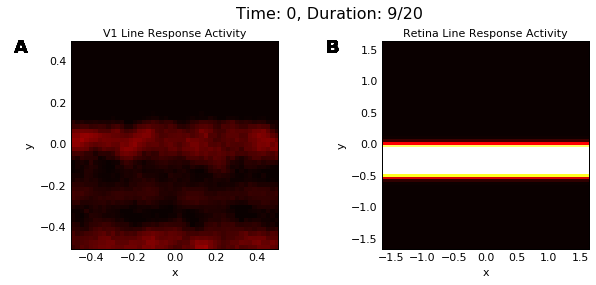
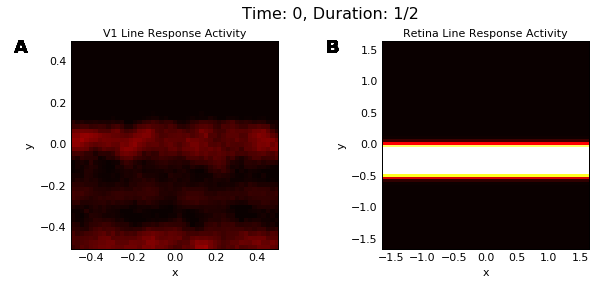
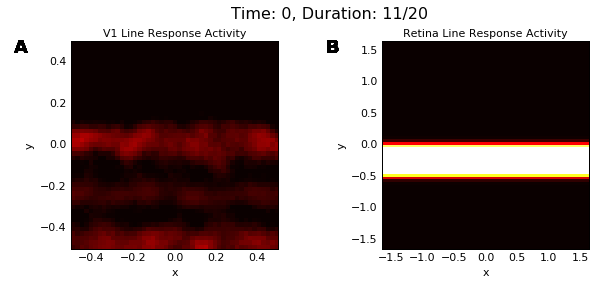
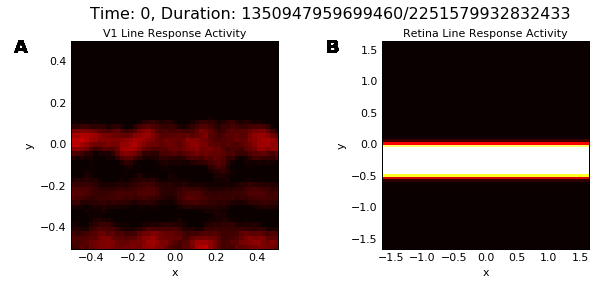
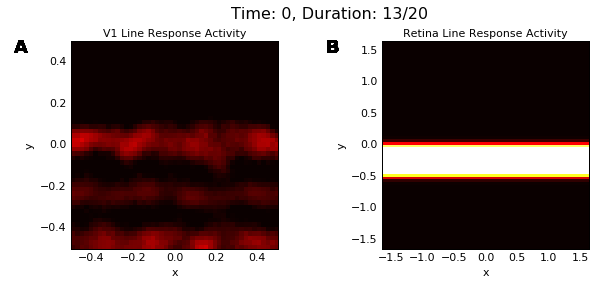
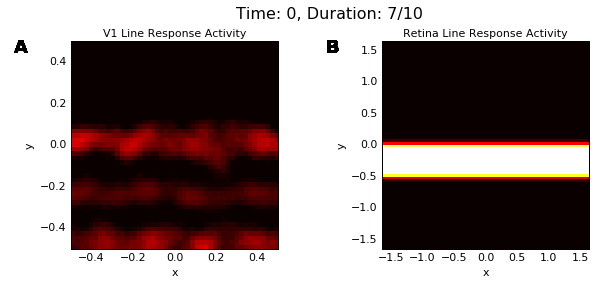
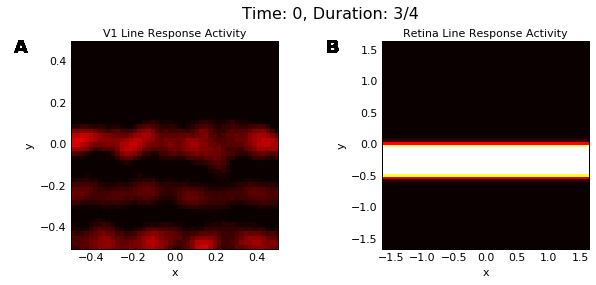
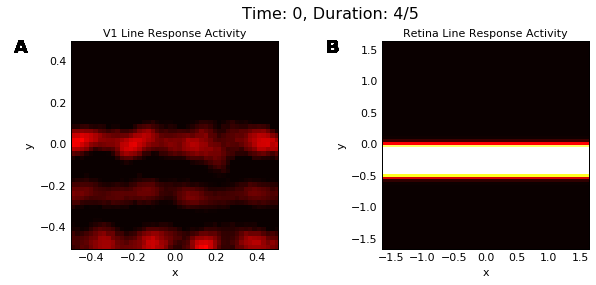
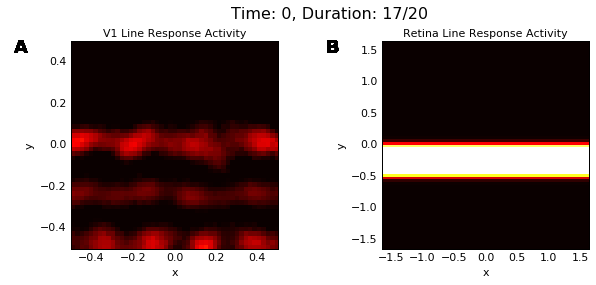
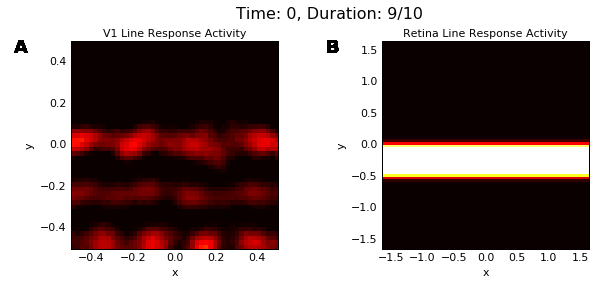
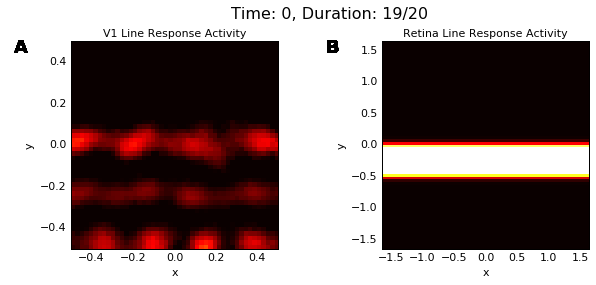
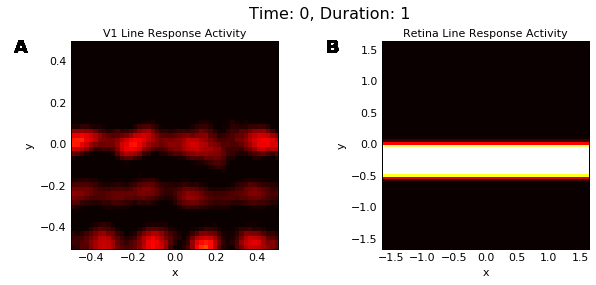
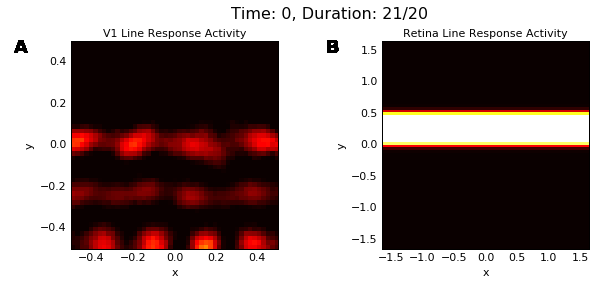
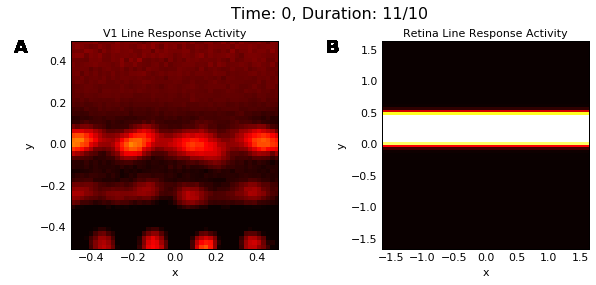
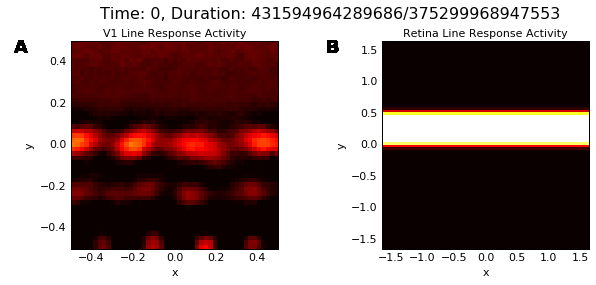
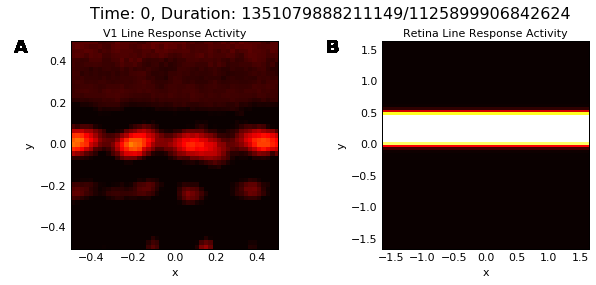
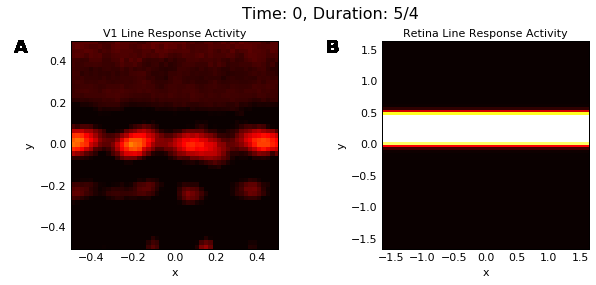
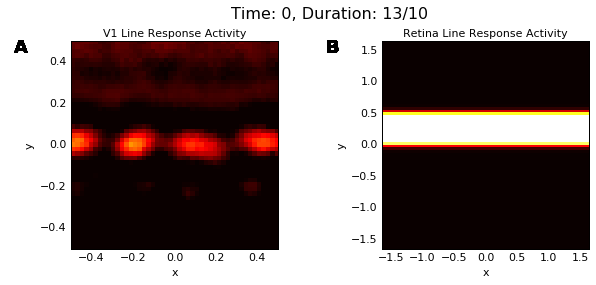
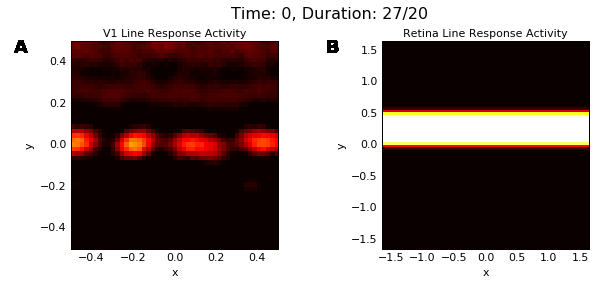
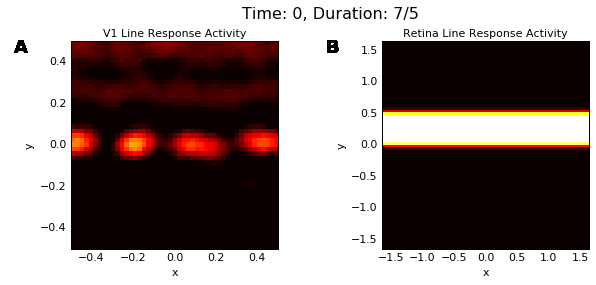
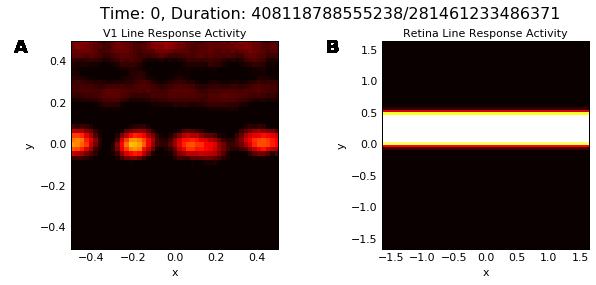
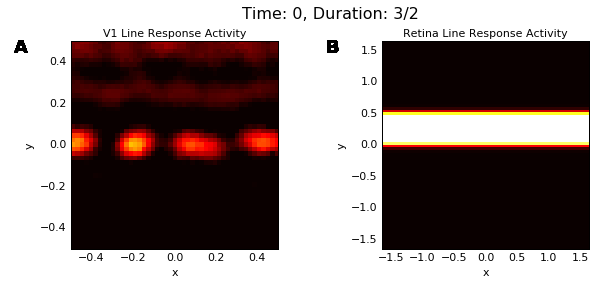
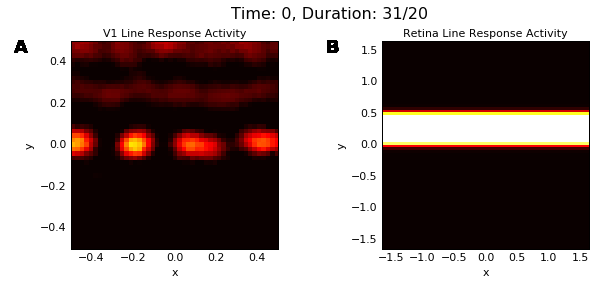
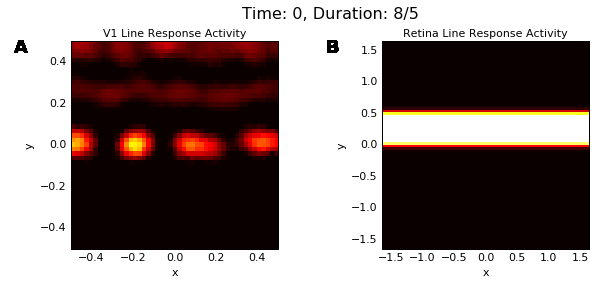
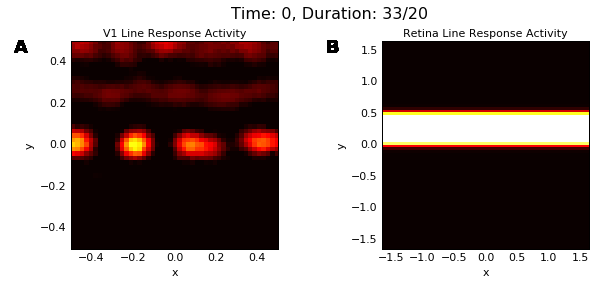
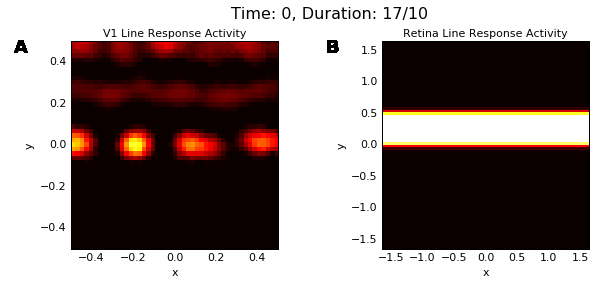
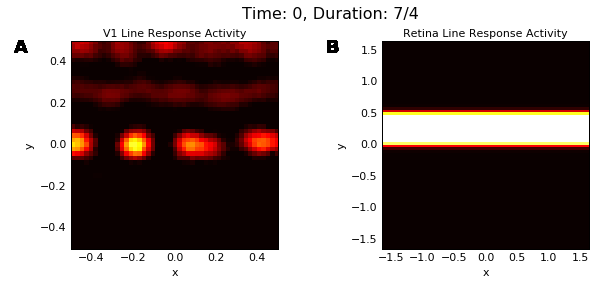
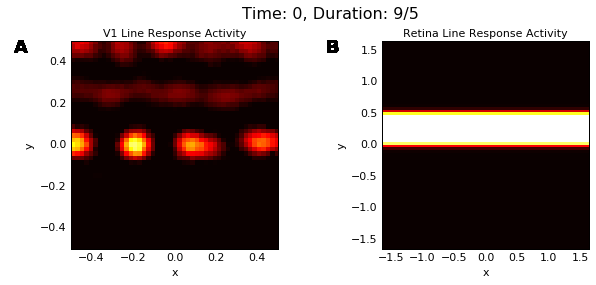
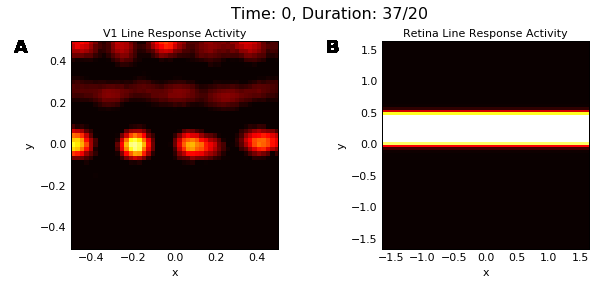
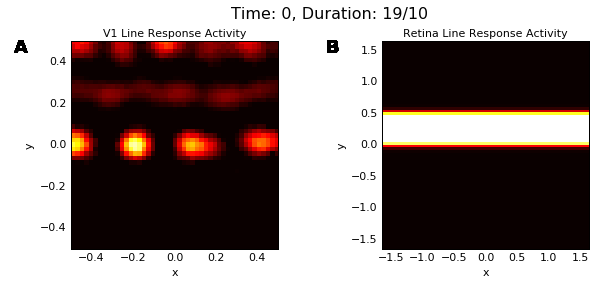
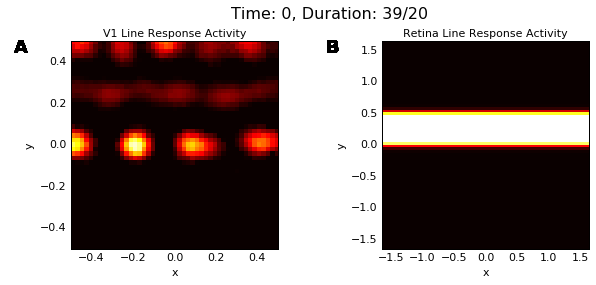
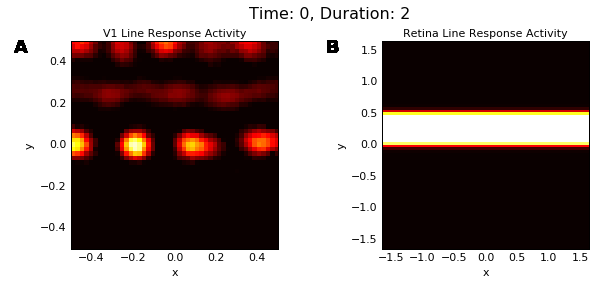
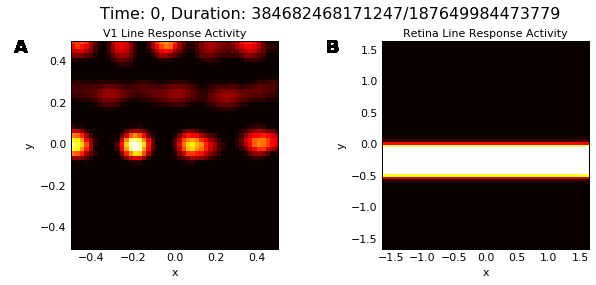

In [11]:
%%output fig='png'
%%opts Image (cmap='hot')
test_pattern = imagen.Line(thickness=0.4, scale=1, y=-0.25+0.5*numbergen.SquareWave(onset=1, duration=1))
measure_response(input_patterns={'Retina':test_pattern}, outputs=['V1','Retina'],
                durations=[0.05*i for i in range(42)])

## Figure 6.2A and Figure 6.2C (CGCAL response)

First let's define the measurement times:

In [12]:
to_5000=[1000*i for i in range(6)]
print 'Times: %s' % ', '.join(str(el) for el in to_5000)

Times: 0, 1000, 2000, 3000, 4000, 5000


Now we can run CGCAL for 5000 iterations:

In [13]:
data = c(times=to_5000)

The following two rows reproduce rows A and C of Figure 6.2:

[Figure 6.2](https://github.com/jlstevens/thesis/blob/master/figures/V1_activity_CGCAL.pdf) : **Comparison of responses to horizontal line in GCAL and CGCAL models after 5000 training iterations.**

:Layout
   .LineResponse.V1     :HoloMap   [Time,Duration]
      :Image   [x,y]   (z)
   .LineResponse.Retina :HoloMap   [Time,Duration]
      :Image   [x,y]   (z)
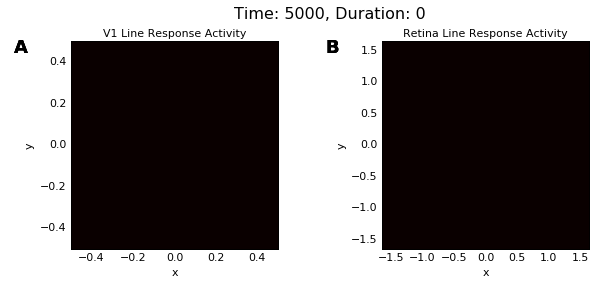
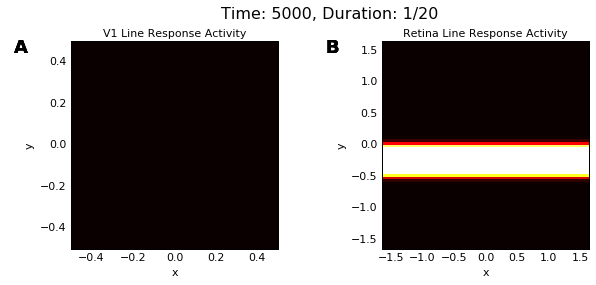
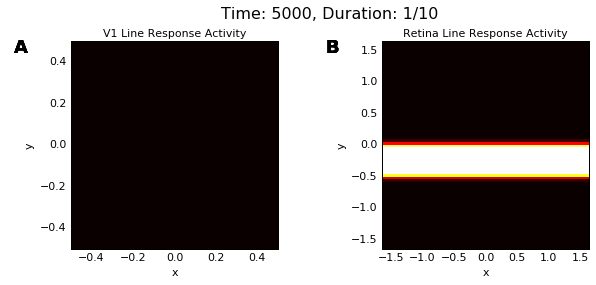
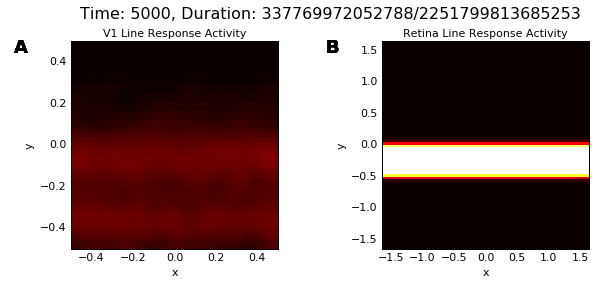
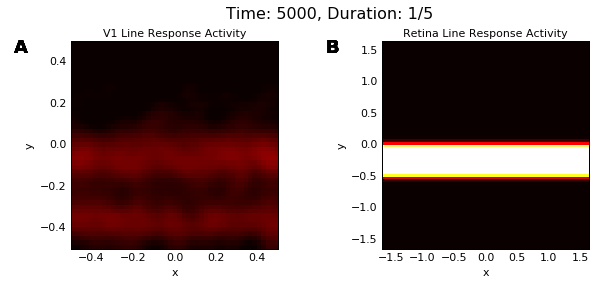
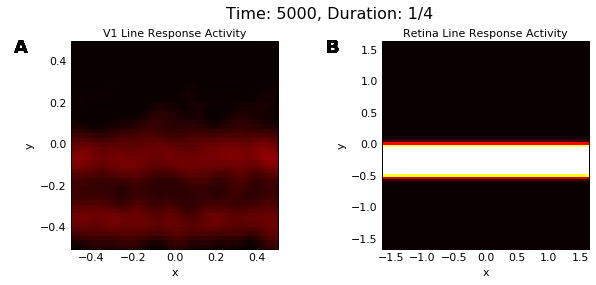
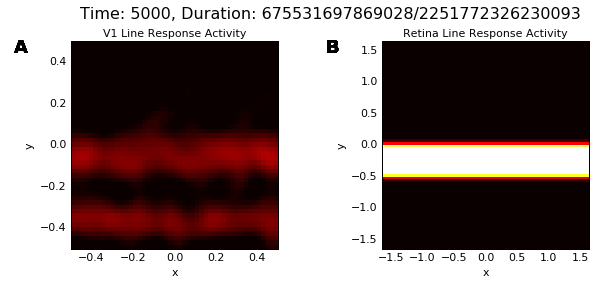
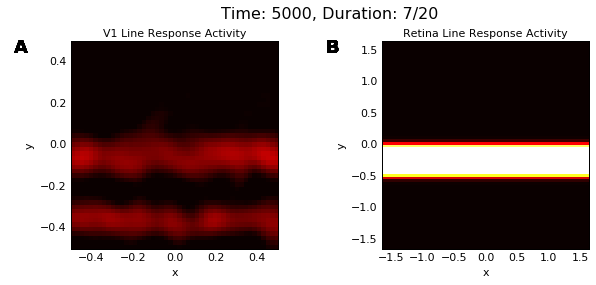
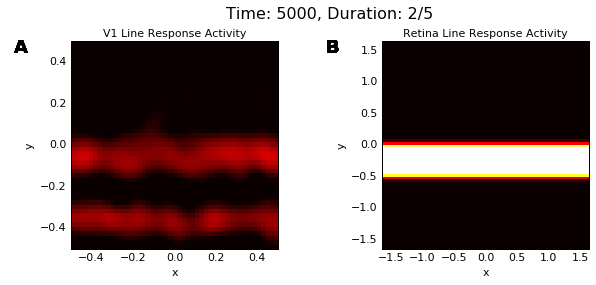
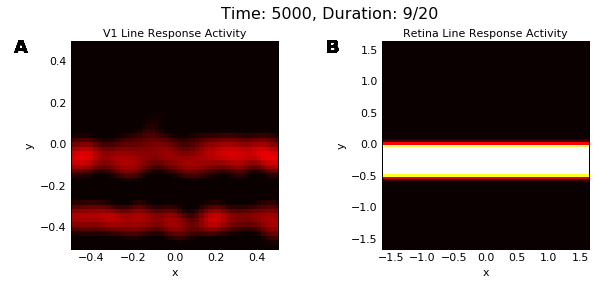
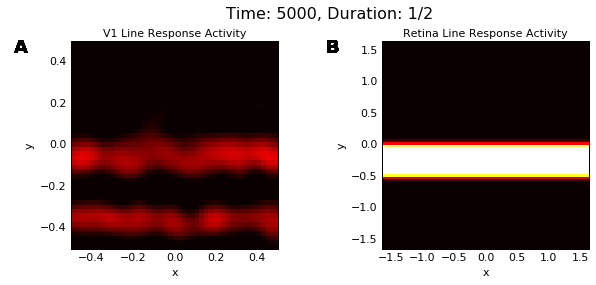
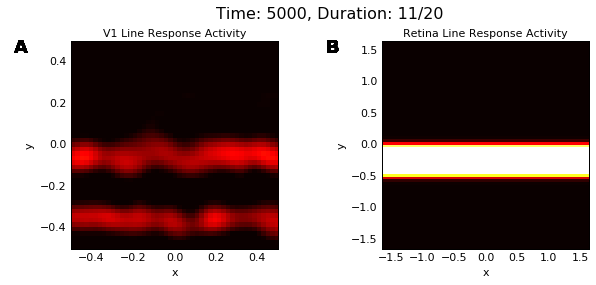
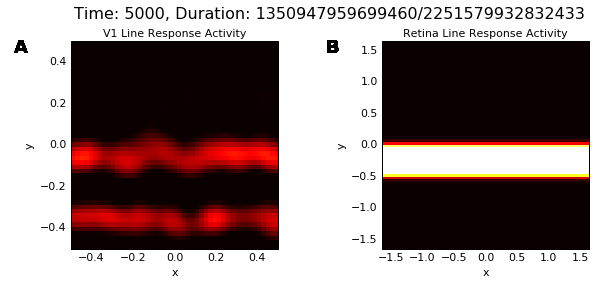
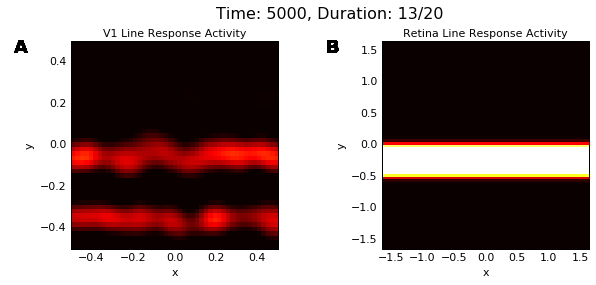
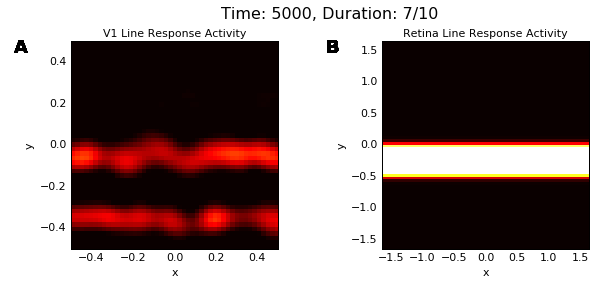
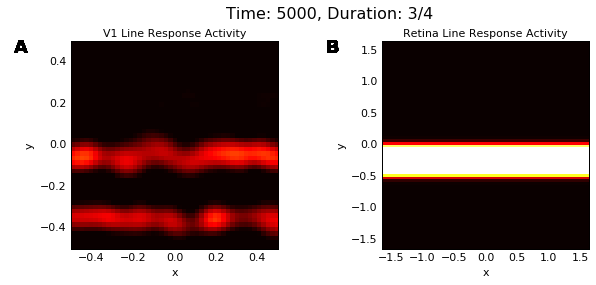
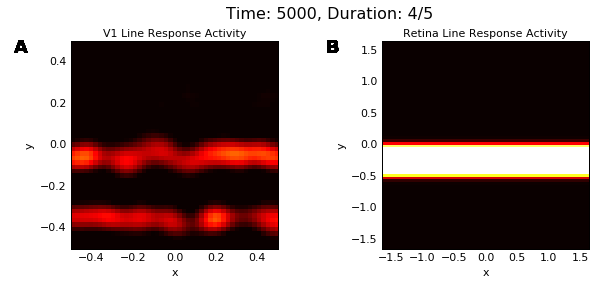
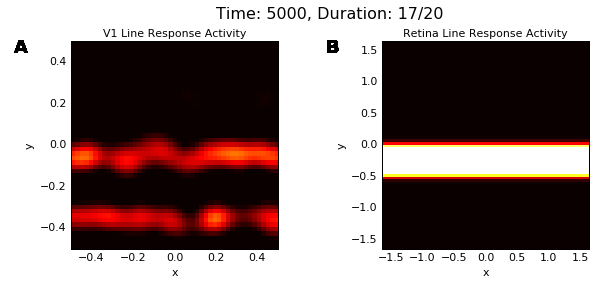
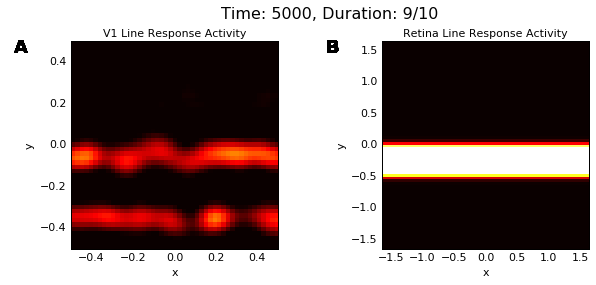
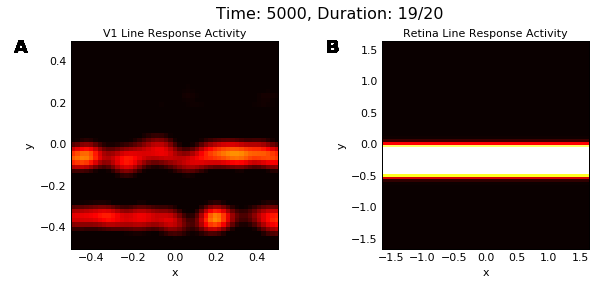
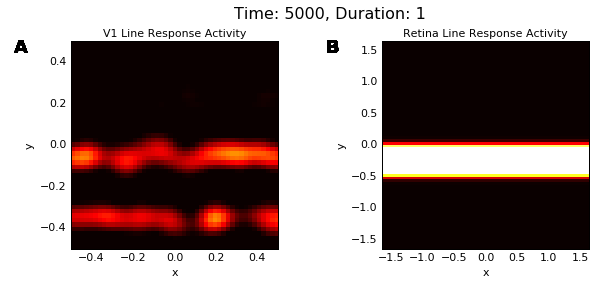
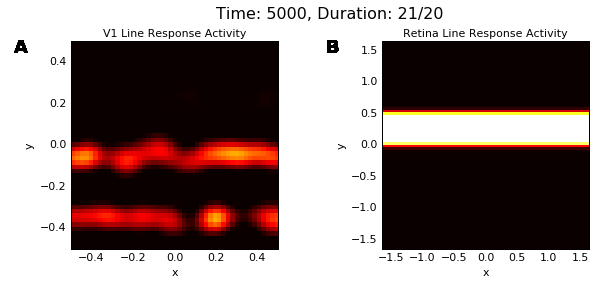
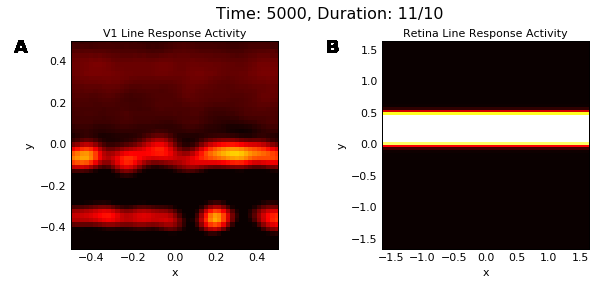
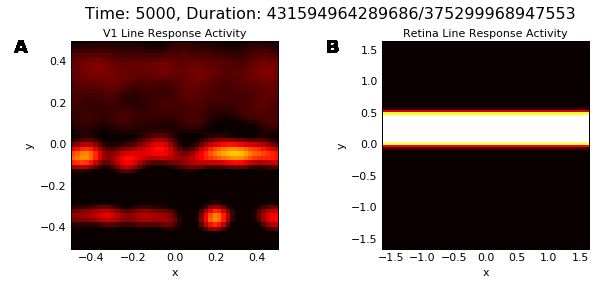
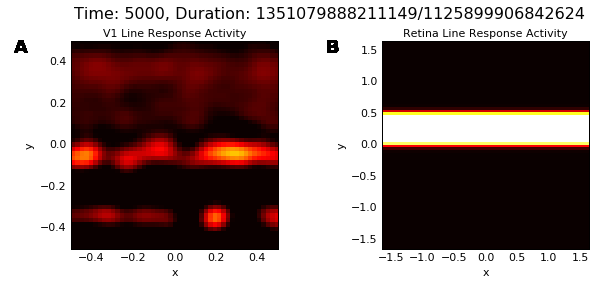
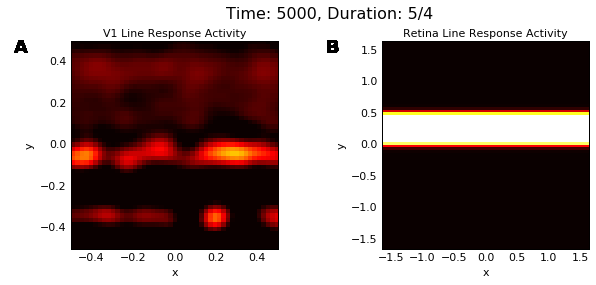
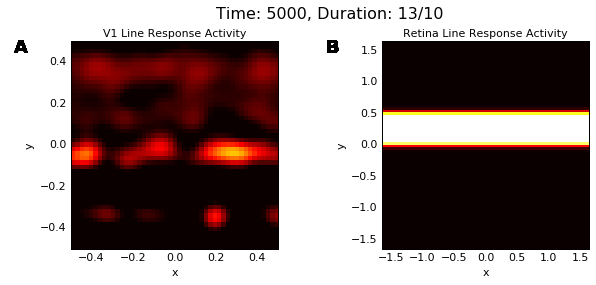
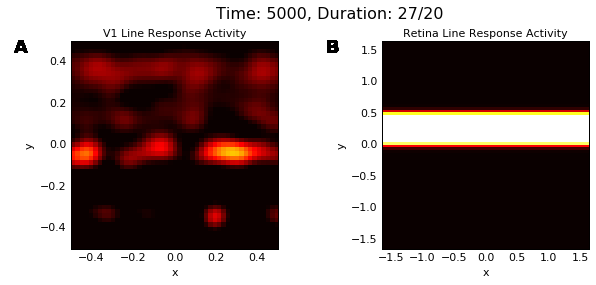
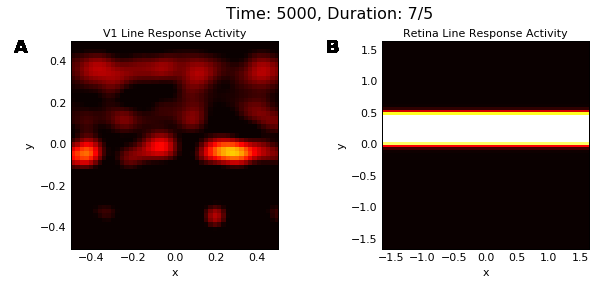
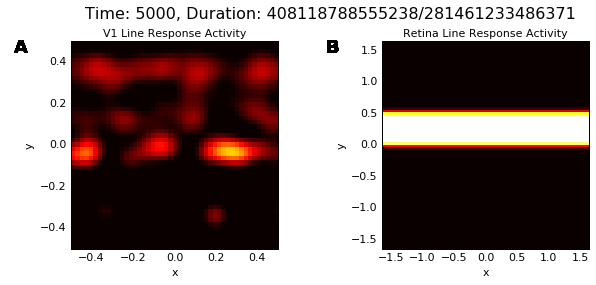
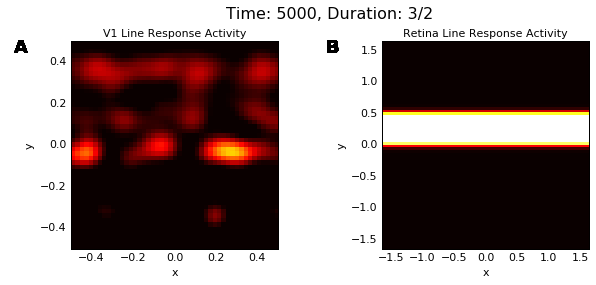
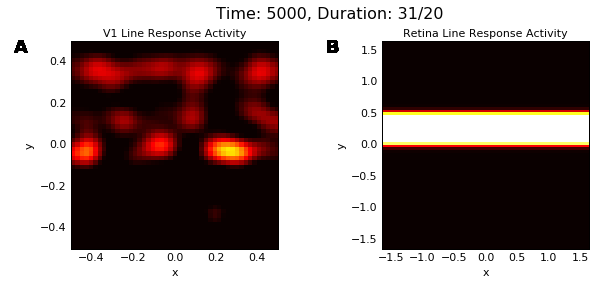
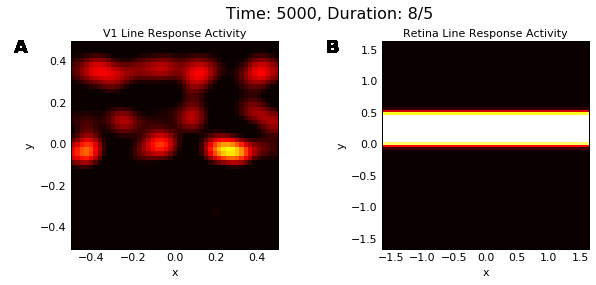
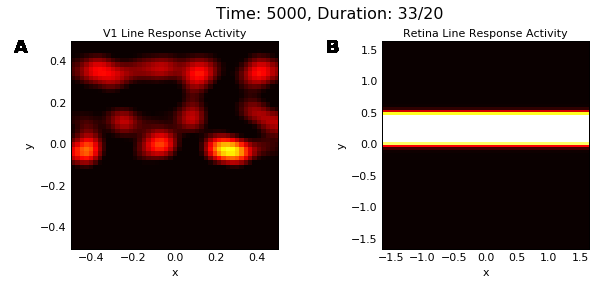
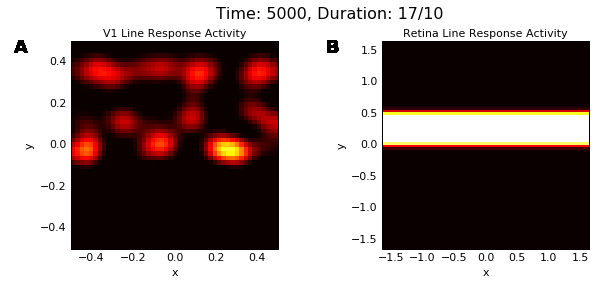
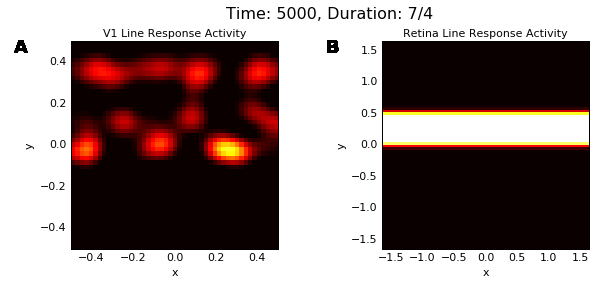
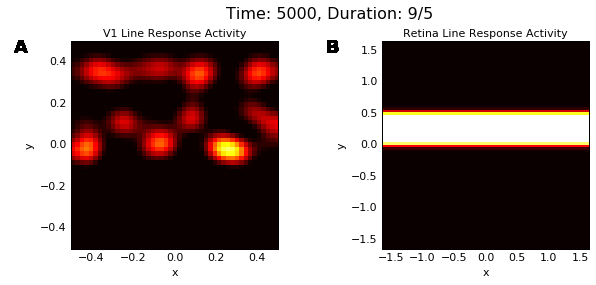
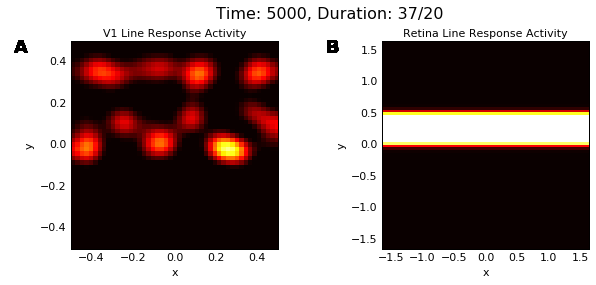
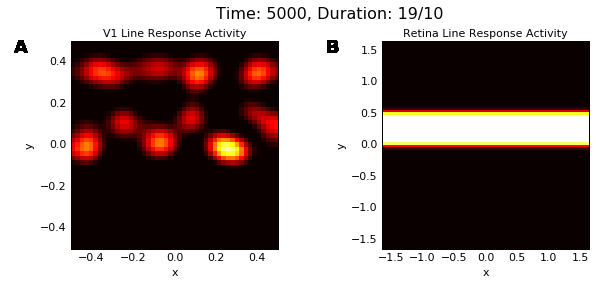
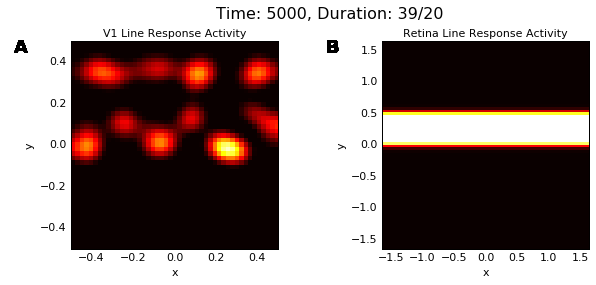
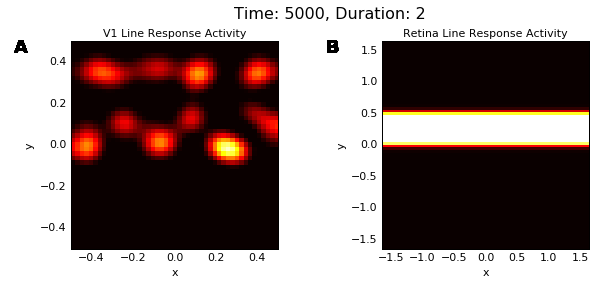
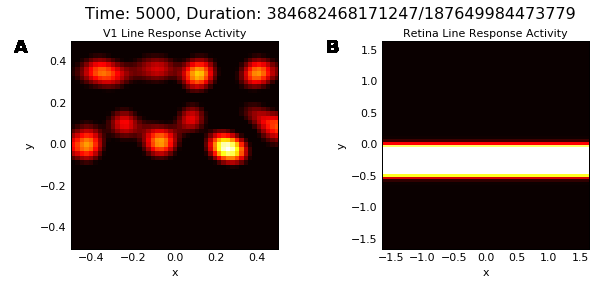

In [14]:
%%output fig='png'
%%opts Image (cmap='hot')
test_pattern = imagen.Line(thickness=0.4, scale=1, y=-0.25+0.5*numbergen.SquareWave(onset=1, duration=1))
line_response = measure_response(input_patterns={'Retina':test_pattern}, outputs=['V1','Retina'],
                durations=[0.05*i for i in range(42)])
line_response

In [15]:
%%opts Image [xaxis=None yaxis=None sublabel_format='' show_title=False](cmap='hot')
keys = [v for (_,v) in line_response.LineResponse.Retina.keys()]
t1,t2,t3,t4 = keys[8], keys[16], keys[24], keys[32]
print 'Times shown (left to right): ' + ', '.join([str(float(5000+t)) for t in [t1,t2,t3,t4]])
(line_response.LineResponse.Retina[(5000,t1)] + line_response.LineResponse.Retina[(5000,t2)] 
 + line_response.LineResponse.Retina[(5000,t3)] + line_response.LineResponse.Retina[(5000,t4)]
 + line_response.LineResponse.V1[(5000,t1)] + line_response.LineResponse.V1[(5000,t2)] 
 + line_response.LineResponse.V1[(5000,t3)] + line_response.LineResponse.V1[(5000,t4)])

Times shown (left to right): 5000.4, 5000.8, 5001.2, 5001.6


:Layout
   .Activity.Retina_Line_Response.I   :Image   [x,y]   (z)
   .Activity.Retina_Line_Response.II  :Image   [x,y]   (z)
   .Activity.Retina_Line_Response.III :Image   [x,y]   (z)
   .Activity.Retina_Line_Response.IV  :Image   [x,y]   (z)
   .Activity.V1_Line_Response.I       :Image   [x,y]   (z)
   .Activity.V1_Line_Response.II      :Image   [x,y]   (z)
   .Activity.V1_Line_Response.III     :Image   [x,y]   (z)
   .Activity.V1_Line_Response.IV      :Image   [x,y]   (z)

## Figure 6.3B (CGCAL OR map)

The following reproduced the CGCAL OR map from Figure 6.3:

[Figure 6.3](https://github.com/jlstevens/thesis/blob/master/figures/CGCAL_OR_map.pdf) : ** Comparison between GCAL and CGCAL orientation maps after 20000 iterations.**

First we define the list of remaining measurement times necessary to reach 20k iterations:

In [16]:
remainder=[1000*i for i in range(6,21)]
print 'Times: %s' % ', '.join(str(el) for el in remainder)

Times: 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000


Which allows us to continue running the model (note this may take a while to run!):

In [17]:
data = c(data, times=remainder)

Now we can view the measured orientation map for CGCAL and compute the pinwheel density shown in Figure 6.3B:

In [18]:
%%opts Overlay [show_legend=False]
pws = pinwheels.PinwheelAnalysis(data.OrientationPreference.V1.last)
analysis = PowerSpectrumAnalysis(pws)
pws + analysis.PowerSpectrum_Analysis.V1

:Layout
   .PinwheelAnalysis.V1       :Overlay
      .Orientation_Preference.V1 :Image   [x,y]   (Orientation Preference)
      .Real.V1                   :Contours   [x,y]   (Level)
      .Imaginary.V1              :Contours   [x,y]   (Level)
      .Pinwheels.V1              :Points   [x,y]
   .PowerSpectrum_Analysis.V1 :HoloMap   [Index,Frame]
      :ItemTable   (cycles,k_delta,kmax,rho,rho_metric,units_per_hc)

Lastly, we can now view the line response in CGCAL after training:

:Layout
   .LineResponse.V1     :HoloMap   [Time,Duration]
      :Image   [x,y]   (z)
   .LineResponse.Retina :HoloMap   [Time,Duration]
      :Image   [x,y]   (z)
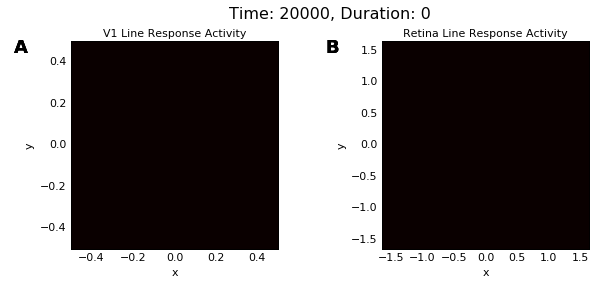
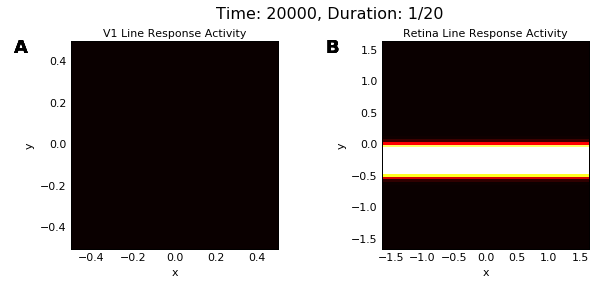
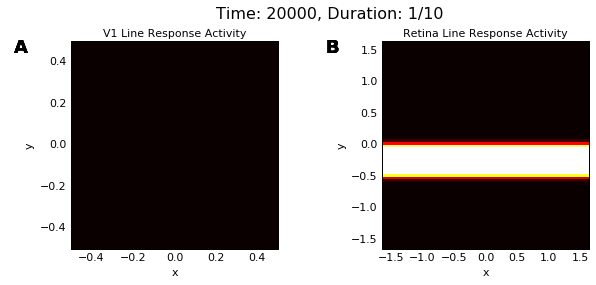
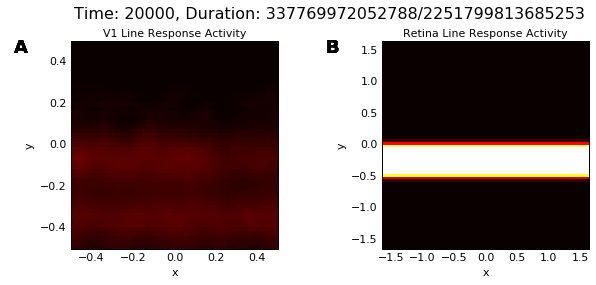
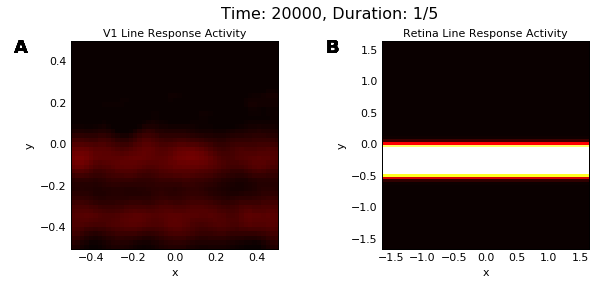
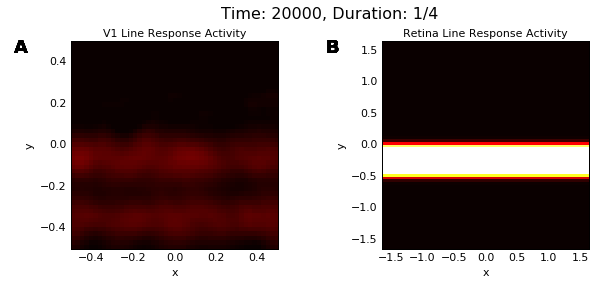
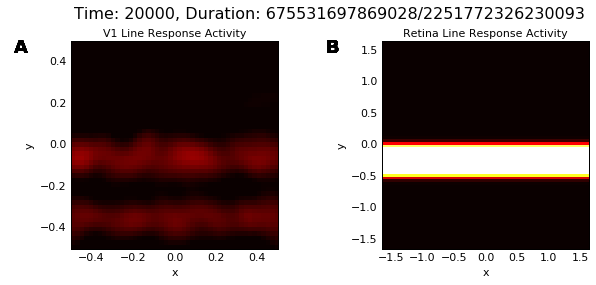
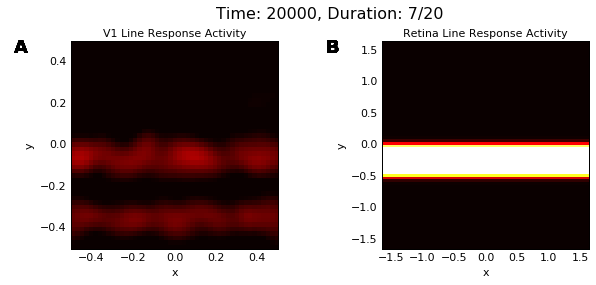
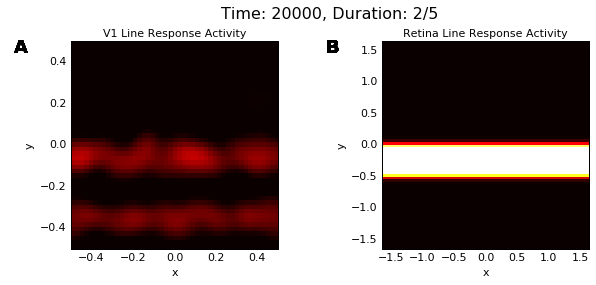
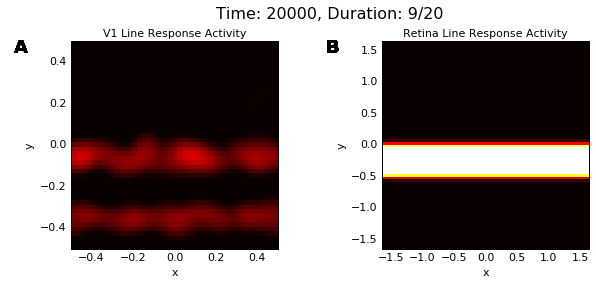
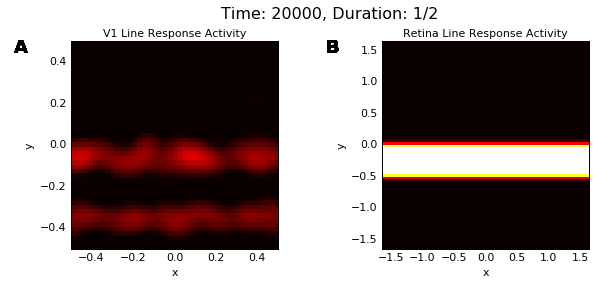
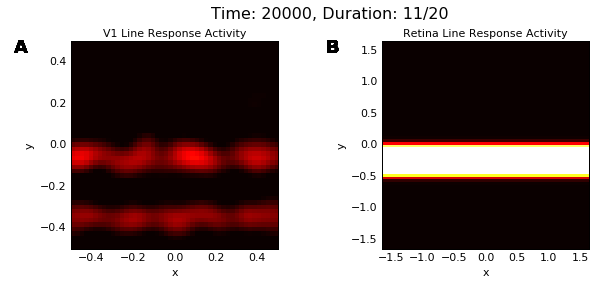
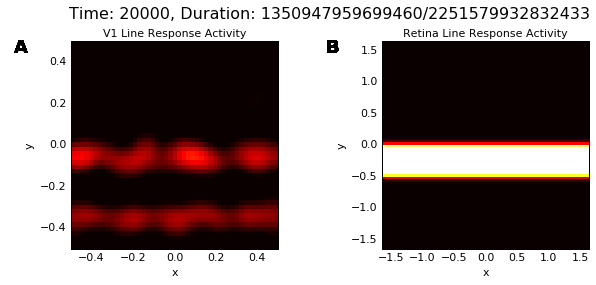
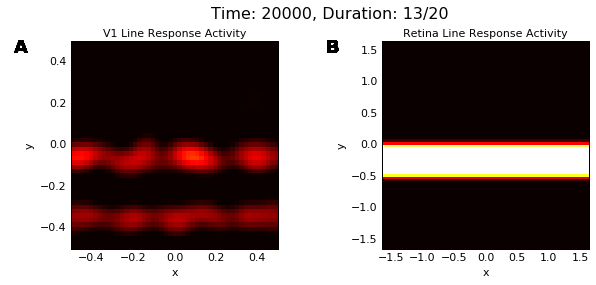
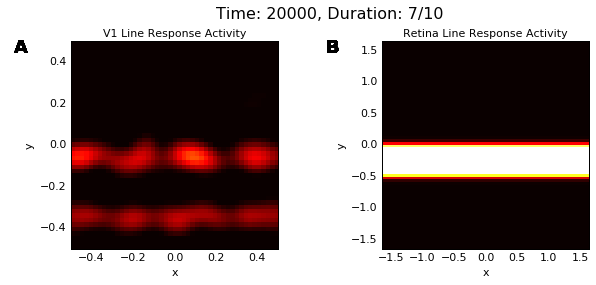
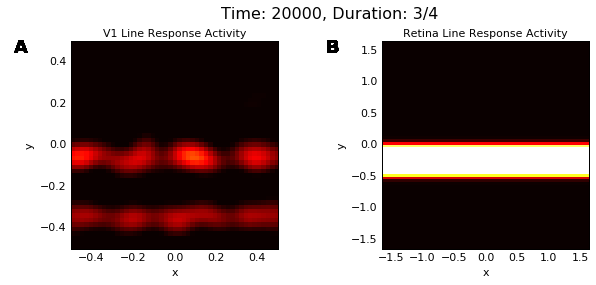
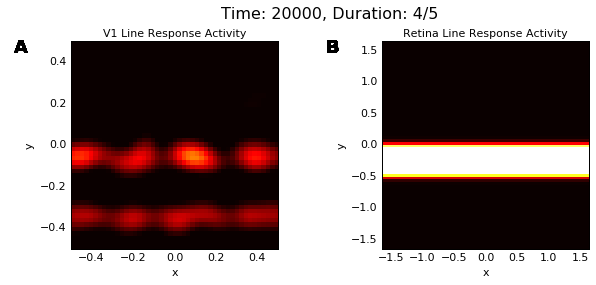
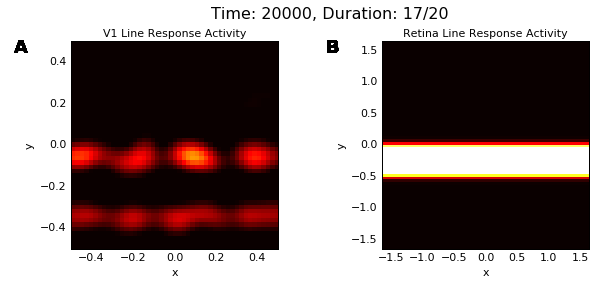
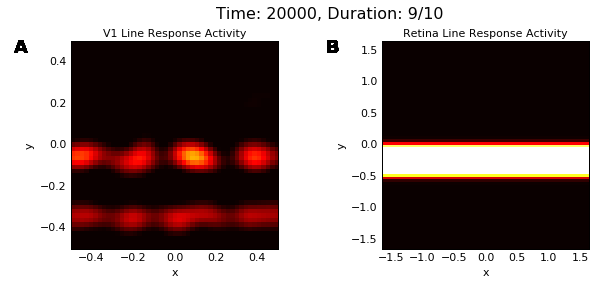
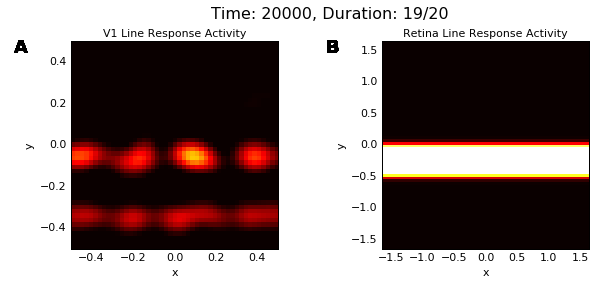
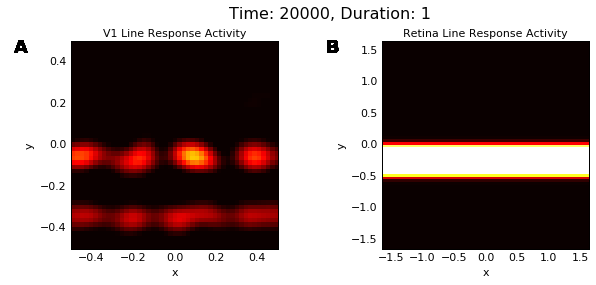
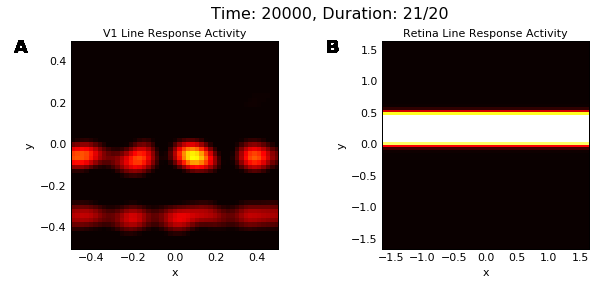
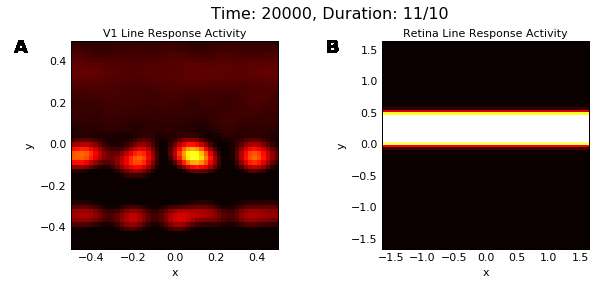
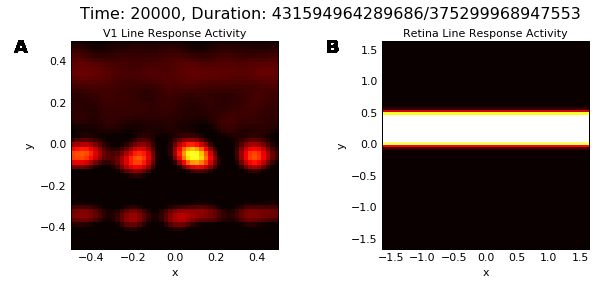
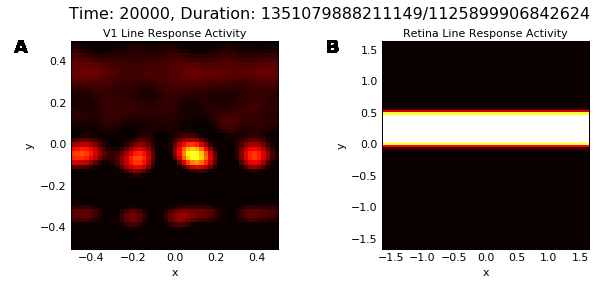
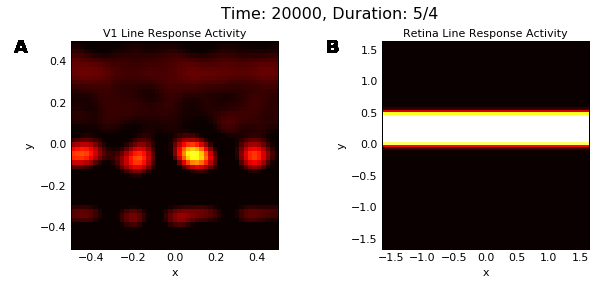
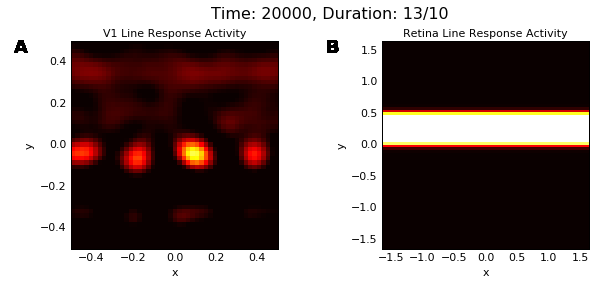
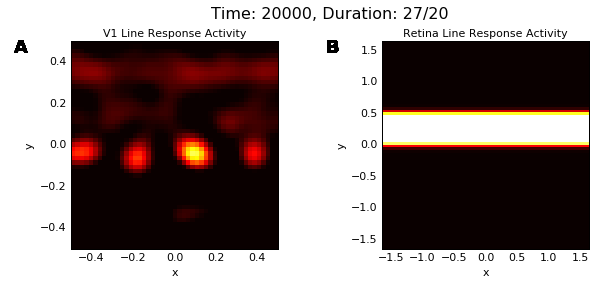
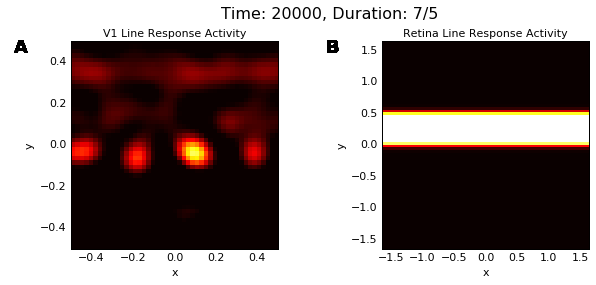
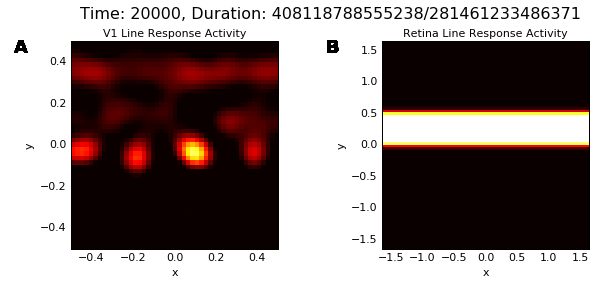
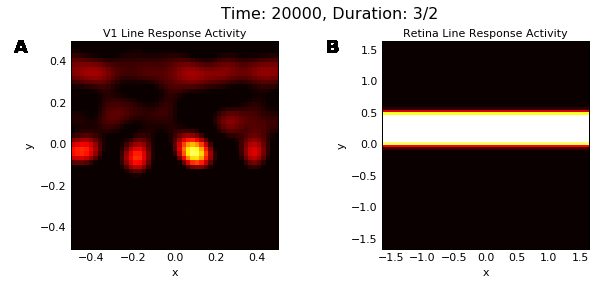
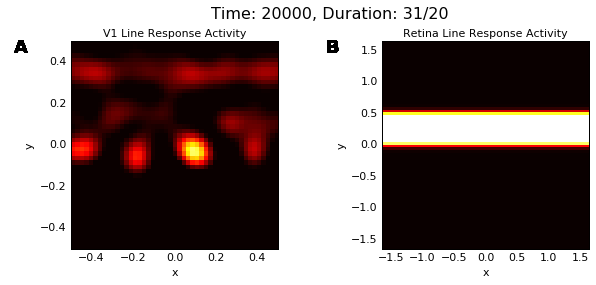
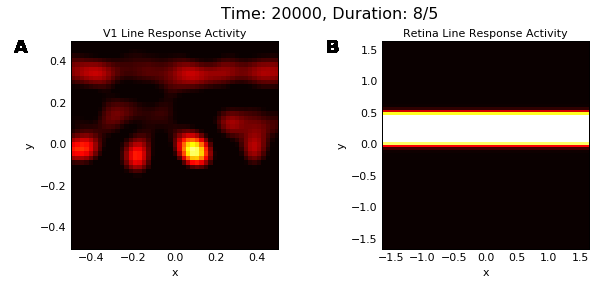
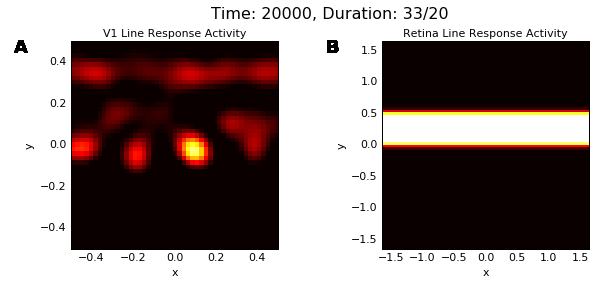
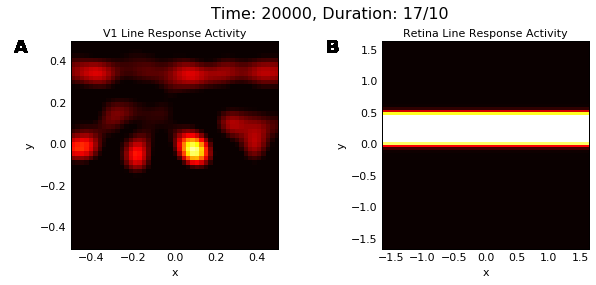
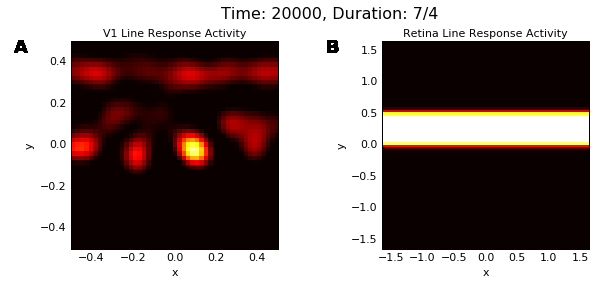
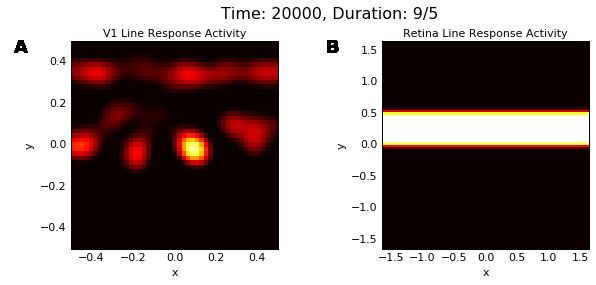
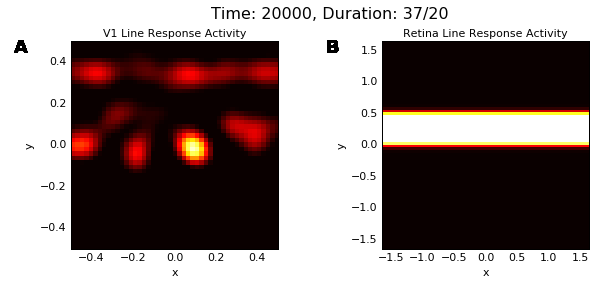
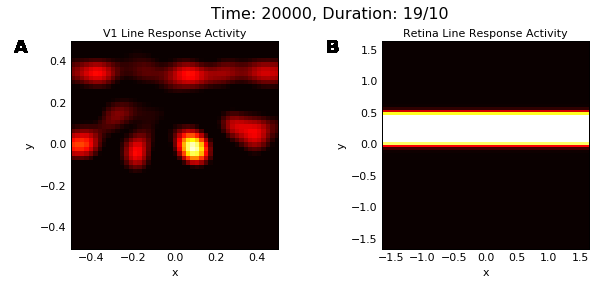
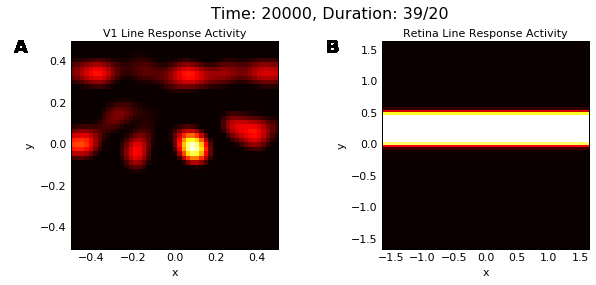
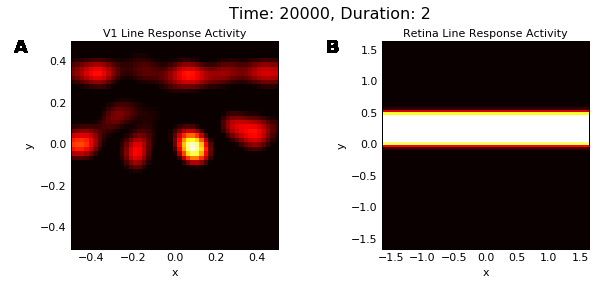
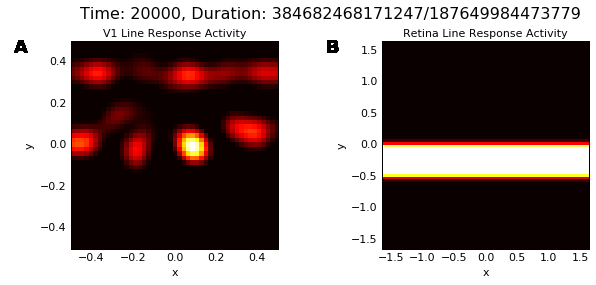

In [19]:
%%output fig='png'
%%opts Image (cmap='hot')
test_pattern = imagen.Line(thickness=0.4, scale=1, y=-0.25+0.5*numbergen.SquareWave(onset=1, duration=1))
measure_response(input_patterns={'Retina':test_pattern}, outputs=['V1','Retina'],
                durations=[0.05*i for i in range(42)])